In [1]:
# Packages 
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns 
import pingouin as pg

from scipy.signal.windows import dpss
from nitime.algorithms.spectral import multi_taper_psd
from mne.time_frequency import psd_array_multitaper
from numpy.lib.stride_tricks import sliding_window_view

from specparam import SpectralModel

from utils.signal_processing import *
from utils.fpp_simulation import *
from utils.plotting import *

In [2]:
def normalize_trace(trace):
    maxval = np.max(trace)
    return trace / maxval

def extract_segment(trace, index_cut):
     return trace[:index_cut]

def compare_kernel_normalized(kernel, kernel_time, psi, psi_time):
    
    psi_norm = normalize_trace(psi)
    
    plt.figure(figsize = (6, 3))
    plt.plot(psi_time, psi_norm, label = '$\Psi$ Pattern (Normalized)', color = 'red', linewidth = 3)
    plt.plot(kernel_time, kernel, label = 'Kernel', color = 'black', linestyle = '--', linewidth = 3)
    
    plt.title('Recovered vs. Original Kernel')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Amplitude')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout()
    plt.show()

def mae(kernel, psi):
    psi_norm = normalize_trace(psi)
    mae = np.mean(np.abs(kernel - psi_norm))
    print(f'Mean Absolute Error: {mae} ({(mae * 100):.2f}%)')

---
##### **Excitation-Inhibition Balance (EIB)**
In this section, we will explore how the balance between two types of kernels coexisting within a single signal determines its temporal dynamics. We will quantify the changes in these dynamics using the two tools previously introduced: the $\Psi$ pattern and the parameterization of the spectral density. 

- Bioelectrical signals such as EEG, ECoG, or LFP are primarily composed of the spatiotemporal superposition of synaptic events. Among these synaptic components, two receptors stand out whose dynamics dominate the signal: AMPA (excitatory) and GABAa (inhibitory).
- The balance between AMPA and GABAa activity has been linked to various biological phenomena, ranging from aging to different neuropathologies.
- We can study the effect of changes in the excitation-inhibition balance using a simple model, generating signals through the superposition of synaptic kernels from both receptors.

##### **1. Pure AMPA Signal**
We set the number of GABAa neurons to zero to visualize a pure excitatory signal.

In [3]:
# Signal parameters 
t_sec, fs = (300, 10000)
window_sec, overlap_sec = (2, 1)

# AMPA parameters 
n_ex, rate_ex, w_ex = (5000, 50, -1)
rise_ampa, decay_ampa = (0.2/1000, 2/1000) 

# GABA parameters
n_in, rate_in, w_in = (0, 0, 1)
rise_gaba, decay_gaba = (0.5/1000, 10/1000) 

# AMPA kernel
kernel_ampa, time_ampa = dual_exponential(t_sec = t_sec, 
                                          fs = fs, 
                                          tau_rise_s = rise_ampa,
                                          tau_decay_s = decay_ampa, 
                                          max_amplitude = 1)

# GABAa kernel
kernel_gaba, time_gaba = dual_exponential(t_sec = t_sec, 
                                          fs = fs, 
                                          tau_rise_s = rise_gaba,
                                          tau_decay_s = decay_gaba, 
                                          max_amplitude = 1)

# Computing the signal
lfp_ampa, _, _, time_lfp_ampa = simulate_fpp_balance(kernel_ex = kernel_ampa, 
                                                     kernel_in = kernel_gaba, 
                                                     fs = fs, 
                                                     t_sec = t_sec, 
                                                     n_ex = n_ex, 
                                                     n_in = n_in, 
                                                     rate_ex = rate_ex, 
                                                     rate_in = rate_in,
                                                     w_ex = w_ex,
                                                     w_in = w_in)

# PSD 
psd_ampa, freqs_ampa = averaged_multitaper_psd(signal = lfp_ampa, fs = fs, window_sec = window_sec, overlap_sec = overlap_sec, NW = 3)
# Recovering the kernel
psi_ampa, time_psi_ampa = averaged_psi_pattern(signal = lfp_ampa, fs = fs, window_sec = window_sec, overlap_sec = overlap_sec)

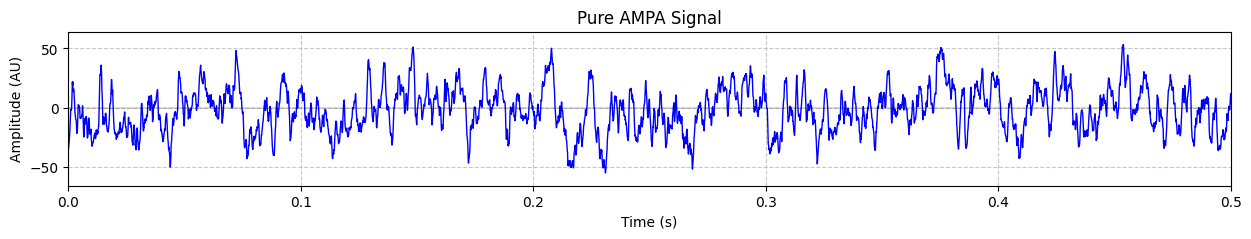

In [4]:
plot_trace(lfp_ampa, time_lfp_ampa, title = 'Pure AMPA Signal', size = (15, 2), xlim = (0, 0.5), trace_color = 'blue', linewidth = 1)

As expected, the $\Psi$ pattern recovers an excellent approximation of the AMPA synaptic kernel.

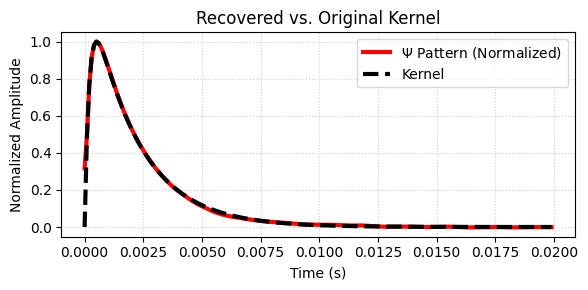

In [5]:
# We will only compare the important segment (first 20 ms)
time_cut = int(0.020 * fs)
kernel_ampa_seg, time_ker_ampa_seg = extract_segment(kernel_ampa, time_cut), extract_segment(time_ampa, time_cut)
psi_ampa_seg, time_psi_ampa_seg = extract_segment(psi_ampa, time_cut), extract_segment(time_psi_ampa, time_cut)

compare_kernel_normalized(kernel = kernel_ampa_seg, kernel_time = time_ker_ampa_seg, psi = psi_ampa_seg, psi_time = time_psi_ampa_seg)

In [6]:
# Error between recovered vs. original kernel
mae(kernel_ampa_seg, psi_ampa_seg)

Mean Absolute Error: 0.0037633242611507345 (0.38%)


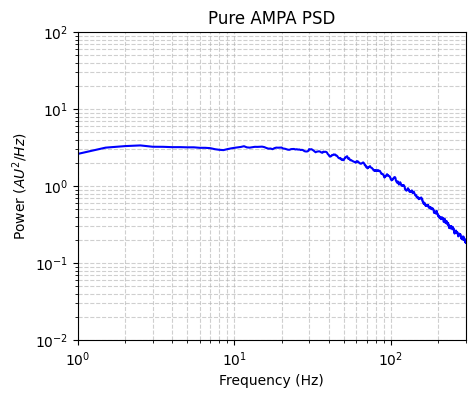

In [7]:
# PSD
plot_psd_log(psd = psd_ampa, freqs = freqs_ampa, xlim = (1, 300), ylim = (10 ** -2, 10 ** 2), title = 'Pure AMPA PSD', color = 'blue')

##### **2. Pure GABAa Signal**

In [8]:
# Signal parameters 
t_sec, fs = (300, 10000)
window_sec, overlap_sec = (2, 1)

# AMPA parameters 
n_ex, rate_ex, w_ex = (0, 0, -1)
rise_ampa, decay_ampa = (0.2/1000, 2/1000) 

# GABA parameters
n_in, rate_in, w_in = (5000, 50, 1)
rise_gaba, decay_gaba = (0.5/1000, 10/1000) 

# AMPA kernel
kernel_ampa, time_ampa = dual_exponential(t_sec = t_sec, 
                                          fs = fs, 
                                          tau_rise_s = rise_ampa,
                                          tau_decay_s = decay_ampa, 
                                          max_amplitude = 1)

# GABAa kernel
kernel_gaba, time_gaba = dual_exponential(t_sec = t_sec, 
                                          fs = fs, 
                                          tau_rise_s = rise_gaba,
                                          tau_decay_s = decay_gaba, 
                                          max_amplitude = 1)

# Computing the signal
lfp_gaba, _, _, time_lfp_gaba = simulate_fpp_balance(kernel_ex = kernel_ampa, 
                                                     kernel_in = kernel_gaba, 
                                                     fs = fs, 
                                                     t_sec = t_sec, 
                                                     n_ex = n_ex, 
                                                     n_in = n_in, 
                                                     rate_ex = rate_ex, 
                                                     rate_in = rate_in,
                                                     w_ex = w_ex,
                                                     w_in = w_in)

# PSD 
psd_gaba, freqs_gaba = averaged_multitaper_psd(signal = lfp_gaba, fs = fs, window_sec = window_sec, overlap_sec = overlap_sec, NW = 3)
# Recovering the kernel
psi_gaba, time_psi_gaba = averaged_psi_pattern(signal = lfp_gaba, fs = fs, window_sec = window_sec, overlap_sec = overlap_sec)

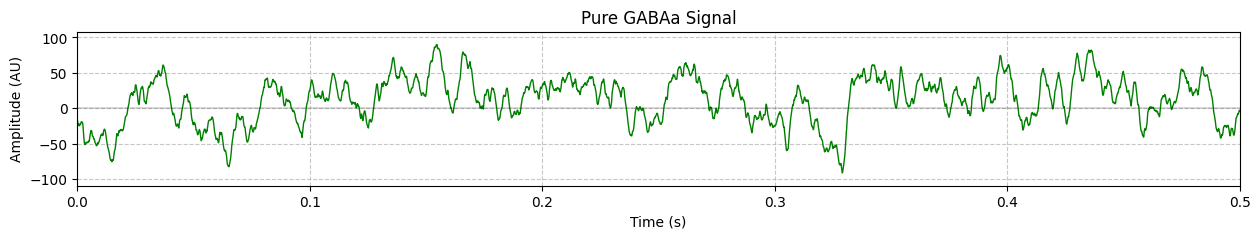

In [9]:
plot_trace(lfp_gaba, time_lfp_gaba, title = 'Pure GABAa Signal', size = (15, 2), xlim = (0, 0.5), trace_color = 'green', linewidth = 1)

Now the $\Psi$ pattern resembles de GABAa kernel.

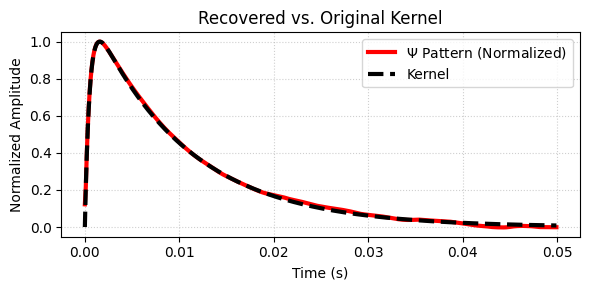

In [10]:
# We will only compare the important segment (first 20 ms)
time_cut = int(0.05 * fs)
kernel_gaba_seg, time_ker_gaba_seg = extract_segment(kernel_gaba, time_cut), extract_segment(time_gaba, time_cut)
psi_gaba_seg, time_psi_gaba_seg = extract_segment(psi_gaba, time_cut), extract_segment(time_psi_gaba, time_cut)

compare_kernel_normalized(kernel = kernel_gaba_seg, kernel_time = time_ker_gaba_seg, psi = psi_gaba_seg, psi_time = time_psi_gaba_seg)

In [11]:
# Error between recovered vs. original kernel
mae(kernel_gaba_seg, psi_gaba_seg)

Mean Absolute Error: 0.005880186338636256 (0.59%)


The pure GABAa PSD is also very different from the pure AMPA PSD.

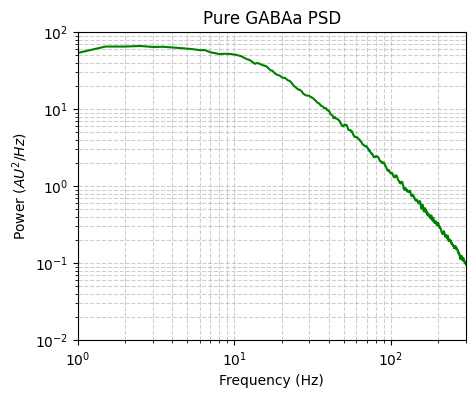

In [12]:
# PSD
plot_psd_log(psd = psd_gaba, freqs = freqs_gaba, xlim = (1, 300), ylim = (10 ** -2, 10 ** 2), title = 'Pure GABAa PSD', color = 'green')

##### **3. AMPA/GABAa Signal (1:1 Ratio)**
Now, the signal will be composed of the superposition of both synaptic kernels. The number of neurons and the firing frequency for both AMPA and GABAa will be identical; therefore, the balance will be at a 1:1 ratio.

In [13]:
# Signal parameters 
t_sec, fs = (300, 10000)
window_sec, overlap_sec = (2, 1)

# AMPA parameters 
n_ex, rate_ex, w_ex = (5000, 50, -1)
rise_ampa, decay_ampa = (0.2/1000, 2/1000) 

# GABA parameters
n_in, rate_in, w_in = (5000, 50, 1)
rise_gaba, decay_gaba = (0.5/1000, 10/1000) 

# AMPA kernel
kernel_ampa, time_ampa = dual_exponential(t_sec = t_sec, 
                                          fs = fs, 
                                          tau_rise_s = rise_ampa,
                                          tau_decay_s = decay_ampa, 
                                          max_amplitude = 1)

# GABAa kernel
kernel_gaba, time_gaba = dual_exponential(t_sec = t_sec, 
                                          fs = fs, 
                                          tau_rise_s = rise_gaba,
                                          tau_decay_s = decay_gaba, 
                                          max_amplitude = 1)

# Computing the signal
lfp_half, lfp_ex, lfp_in, time_lfp_half = simulate_fpp_balance(kernel_ex = kernel_ampa, 
                                                               kernel_in = kernel_gaba, 
                                                               fs = fs, 
                                                               t_sec = t_sec, 
                                                               n_ex = n_ex, 
                                                               n_in = n_in, 
                                                               rate_ex = rate_ex, 
                                                               rate_in = rate_in,
                                                               w_ex = w_ex,
                                                               w_in = w_in)

# PSD 
psd_half, freqs_half = averaged_multitaper_psd(signal = lfp_half, fs = fs, window_sec = window_sec, overlap_sec = overlap_sec, NW = 3)
# Recovering the kernel
psi_half, time_psi_half = averaged_psi_pattern(signal = lfp_half, fs = fs, window_sec = window_sec, overlap_sec = overlap_sec)

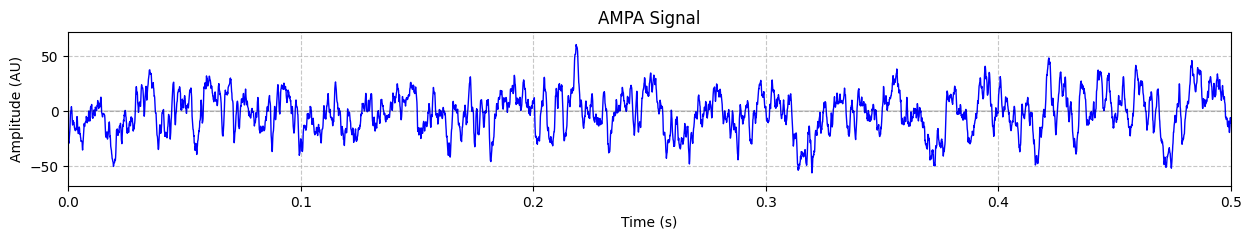

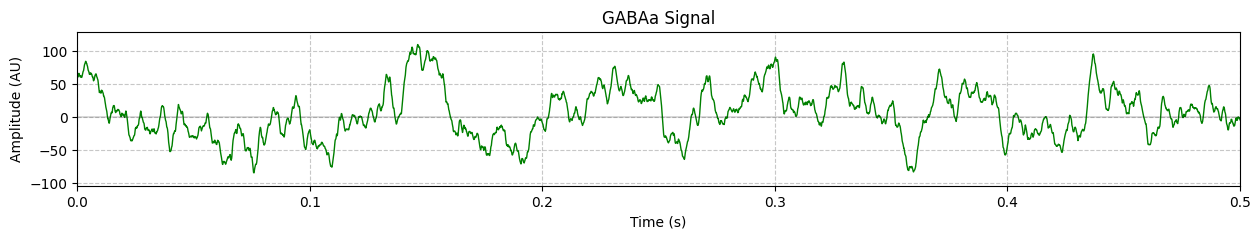

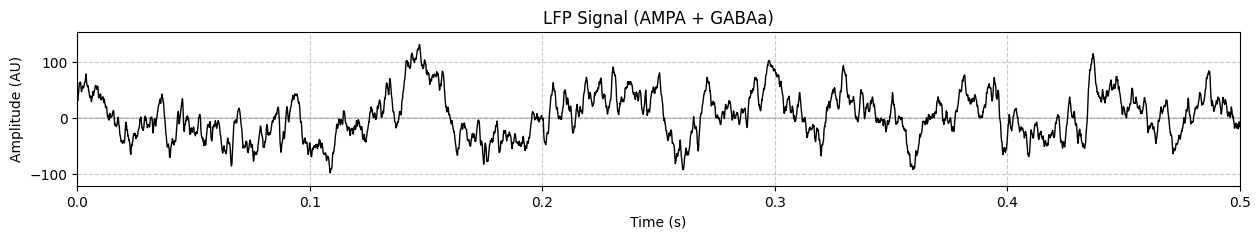

In [14]:
plot_trace(lfp_ex, time_lfp_half, title = 'AMPA Signal', size = (15, 2), xlim = (0, 0.5), trace_color = 'blue', linewidth = 1)
plot_trace(lfp_in, time_lfp_half, title = 'GABAa Signal', size = (15, 2), xlim = (0, 0.5), trace_color = 'green', linewidth = 1)
plot_trace(lfp_half, time_lfp_half, title = 'LFP Signal (AMPA + GABAa)', size = (15, 2), xlim = (0, 0.5), trace_color = 'black', linewidth = 1)

We note that the $\Psi$ pattern is now not exactly identical to either the AMPA or GABAa synaptic kernels; instead, it corresponds to a sort of mixture (linear combination) of the two.

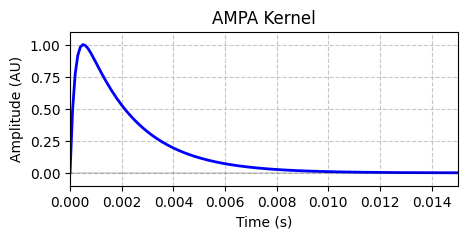

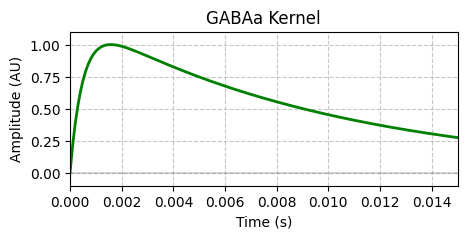

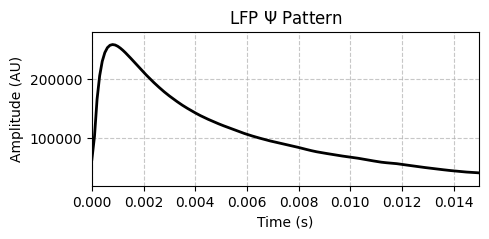

In [15]:
plot_trace(kernel_ampa, time_ampa, title = 'AMPA Kernel', xlim = (0, 0.015), trace_color = 'blue')
plot_trace(kernel_gaba, time_gaba, title = 'GABAa Kernel', xlim = (0, 0.015), trace_color = 'green')
plot_trace(psi_half, time_psi_half, title = 'LFP $\Psi$ Pattern', xlim = (0, 0.015), trace_color = 'black')

Finally, lets visualize the three $\Psi$ patterns together. We can easily see that the temporal profile of this pattern contains important information about the balance between excitatory (AMPA) and inhibitory (GABAa) events.

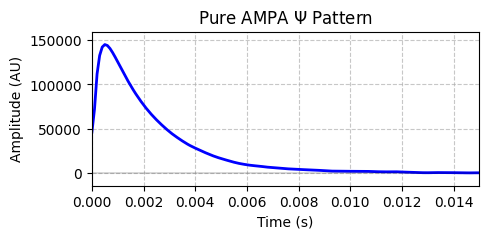

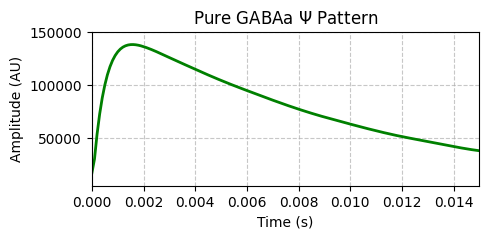

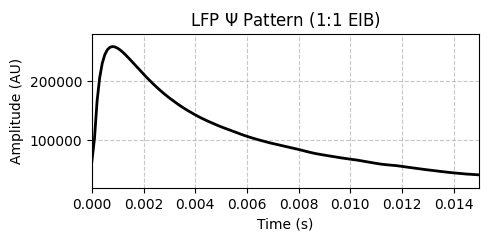

In [16]:
plot_trace(psi_ampa, time_psi_ampa, title = 'Pure AMPA $\Psi$ Pattern', xlim = (0, 0.015), trace_color = 'blue')
plot_trace(psi_gaba, time_psi_gaba, title = 'Pure GABAa $\Psi$ Pattern', xlim = (0, 0.015), trace_color = 'green')
plot_trace(psi_half, time_psi_half, title = 'LFP $\Psi$ Pattern (1:1 EIB)', xlim = (0, 0.015), trace_color = 'black')

Something similar happens with the PSD.

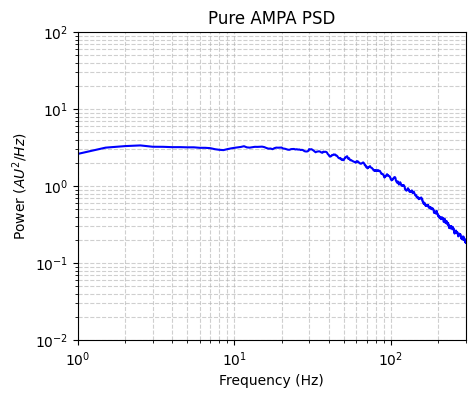

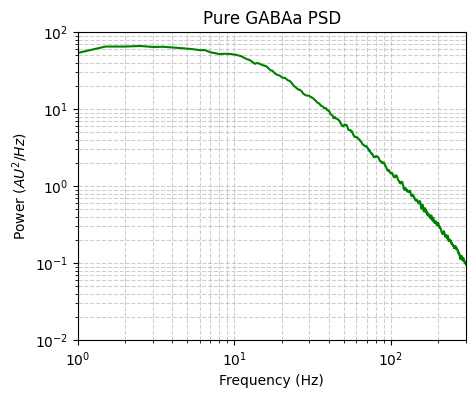

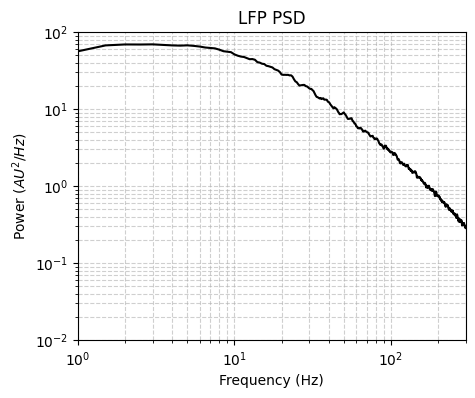

In [17]:
plot_psd_log(psd = psd_ampa, freqs = freqs_ampa, xlim = (1, 300), ylim = (10 ** -2, 10 ** 2), title = 'Pure AMPA PSD', color = 'blue')
plot_psd_log(psd = psd_gaba, freqs = freqs_gaba, xlim = (1, 300), ylim = (10 ** -2, 10 ** 2), title = 'Pure GABAa PSD', color = 'green')
plot_psd_log(psd = psd_half, freqs = freqs_half, xlim = (1, 300), ylim = (10 ** -2, 10 ** 2), title = 'LFP PSD', color = 'black')

---
##### **Quantifying the EIB**
We will now generate a large number of signals with varying EIB values (see *04_synaptic_balance.py*) to evaluate how the $\Psi$ pattern and spectral parameterization allow us to quantify changes in this balance. We will assess several quantification methods:

- The duration of the $\Psi$ pattern, defined as the time required for the pattern to decay to 15% of its maximum amplitude.
- The spectral slope in the 40 – 85 Hz band using specparam in 'fixed' mode.
- The spectral slope in the 1 – 300 Hz band using specparam in 'doublexp' mode.

In [18]:
# Importing the simulated data 
filename = r'C:\Users\marce\Escritorio\Proyectos\synaptic_lfp\simulation_results\eib_simulation_results.csv'
eib_data = pd.read_csv(filename, sep = ',')

print(eib_data.shape)
eib_data.head(5)

(10000, 18)


,sim_id,n_ex,n_in,eib,psi_duration,psi_rise,psi_decay,psi_maxval,offset_linear,exp_linear,mae_linear,r2_linear,offset_dexp,exp_0,knee,exp_1,mae_dexp,r2_dexp
0,0,101,9899,0.010203,0.0208,0.0016,0.0192,278159.767989,4.349715,1.921771,0.012860,0.991801,5.202393,0.194811,985.195213,2.161748,0.025988,0.998127
1,1,9708,292,33.246575,0.0049,0.0005,0.0044,290182.760122,2.186775,0.870969,0.019287,0.916540,4.911362,0.139113,6761.018013,1.997708,0.016101,0.997368
2,2,1378,8622,0.159824,0.0200,0.0014,0.0186,269646.146423,4.252207,1.882248,0.016289,0.988198,5.017704,0.180308,754.948680,2.085453,0.024235,0.998153
3,3,9847,153,64.359477,0.0046,0.0005,0.0041,289962.522510,1.978975,0.768046,0.021350,0.880446,5.034947,0.114854,11012.272070,2.072263,0.016708,0.997115
4,4,3298,6702,0.492092,0.0184,0.0010,0.0174,260163.869196,3.770365,1.638263,0.016736,0.981088,3.577608,-112.513847,42.335084,114.124668,0.106613,0.950965


In [19]:
eib_data.describe()

,sim_id,n_ex,n_in,eib,psi_duration,psi_rise,psi_decay,psi_maxval,offset_linear,exp_linear,mae_linear,r2_linear,offset_dexp,exp_0,knee,exp_1,mae_dexp,r2_dexp
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,5032.927400,4967.072600,11.090638,0.013258,0.000946,0.012313,274686.000454,3.319748,1.424926,0.016493,0.966736,4.561655,-16.681662,1809.639520,18.710662,0.036670,0.985805
std,2886.89568,3789.649128,3789.649128,20.818168,0.006752,0.000416,0.006354,9881.130701,0.914423,0.447090,0.002570,0.027614,0.799888,39.095939,2500.103950,38.800252,0.031140,0.029968
min,0.00000,99.000000,100.000000,0.009999,0.004500,0.000500,0.004000,255242.764145,1.661270,0.586339,0.008205,0.832184,1.916877,-123.330945,0.001741,-1.975366,0.014798,0.817774
25%,2499.75000,942.000000,881.500000,0.103996,0.005500,0.000500,0.005000,266277.460568,2.336481,0.947033,0.014677,0.951865,4.438938,0.120481,379.804654,1.873128,0.021622,0.996353
50%,4999.50000,5059.500000,4940.500000,1.024087,0.014700,0.000800,0.013900,274933.418208,3.542556,1.540654,0.016338,0.979577,4.835632,0.218590,840.757129,2.040018,0.024696,0.997201
75%,7499.25000,9118.500000,9058.000000,10.344310,0.020100,0.001400,0.018700,283203.179323,4.214136,1.856534,0.018142,0.986848,5.103002,0.262352,1330.082943,2.114613,0.026792,0.998027
max,9999.00000,9900.000000,9901.000000,99.000000,0.023200,0.001600,0.021700,292986.808803,4.668314,2.108230,0.028617,0.995842,5.360564,2.199024,13638.629820,124.439439,0.138498,0.998671


In [20]:
# We will transform time values from seconds to milliseconds 
cols = ['psi_duration', 'psi_rise', 'psi_decay']
eib_data[cols] = eib_data[cols] * 1000

eib_data.head(5)

,sim_id,n_ex,n_in,eib,psi_duration,psi_rise,psi_decay,psi_maxval,offset_linear,exp_linear,mae_linear,r2_linear,offset_dexp,exp_0,knee,exp_1,mae_dexp,r2_dexp
0,0,101,9899,0.010203,20.8,1.6,19.2,278159.767989,4.349715,1.921771,0.012860,0.991801,5.202393,0.194811,985.195213,2.161748,0.025988,0.998127
1,1,9708,292,33.246575,4.9,0.5,4.4,290182.760122,2.186775,0.870969,0.019287,0.916540,4.911362,0.139113,6761.018013,1.997708,0.016101,0.997368
2,2,1378,8622,0.159824,20.0,1.4,18.6,269646.146423,4.252207,1.882248,0.016289,0.988198,5.017704,0.180308,754.948680,2.085453,0.024235,0.998153
3,3,9847,153,64.359477,4.6,0.5,4.1,289962.522510,1.978975,0.768046,0.021350,0.880446,5.034947,0.114854,11012.272070,2.072263,0.016708,0.997115
4,4,3298,6702,0.492092,18.4,1.0,17.4,260163.869196,3.770365,1.638263,0.016736,0.981088,3.577608,-112.513847,42.335084,114.124668,0.106613,0.950965


##### **1. EIB and $\Psi$ Pattern Duration**
As the AMPA kernel (whose temporal dynamics are faster) becomes more predominant, its contribution to the $\Psi$ pattern increases, thereby decreasing the pattern's duration.

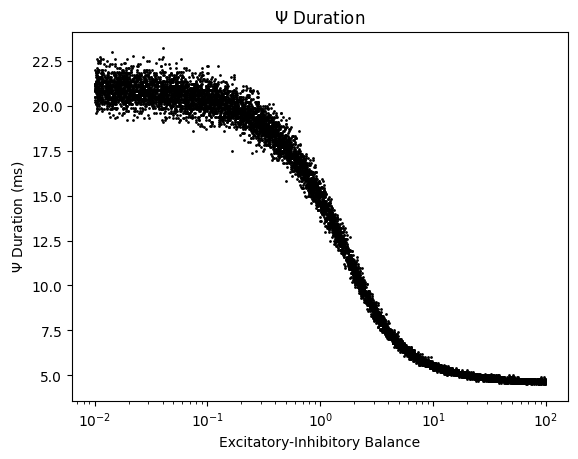

In [21]:
sns.scatterplot(
    x = 'eib', 
    y = 'psi_duration', 
    data = eib_data, 
    s = 1, 
    color = 'black', 
    edgecolor = 'black', 
    linewidth = 1
)

plt.title('$\Psi$ Duration')
plt.xlabel('Excitatory-Inhibitory Balance')
plt.ylabel('$\Psi$ Duration (ms)')
plt.xscale('log')  
plt.show()

In [22]:
is_inf = np.isinf(np.log(eib_data['eib'])).sum()
print(f"Number of infinite values: {is_inf}")

Number of infinite values: 0


Note: The p-value and BF10 appear as NaN because the correlation is so strong that the values effectively underflow to zero.

In [23]:
# Spearman correlation between log(eib) and psi_duration
pg.corr(x = np.log(eib_data['eib']), y = eib_data['psi_duration'], method = 'pearson') 

,n,r,CI95%,p-val,BF10,power
pearson,10000,-0.957274,"[-0.96, -0.96]",0.0,nan,1.0


##### **2. EIB and Spectral Parameterization (Fixed Mode in 40 - 85 Hz Frequency Range)**

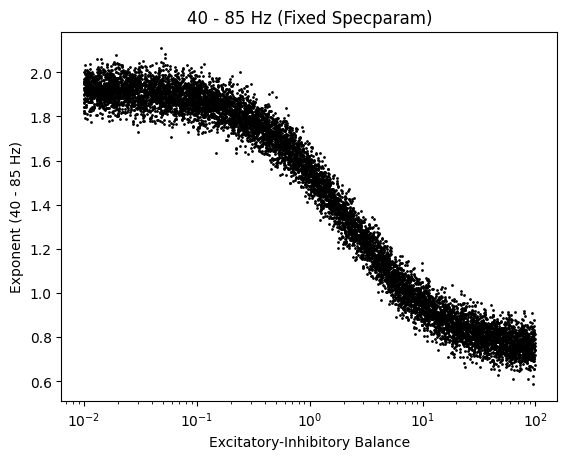

In [24]:
sns.scatterplot(
    x = 'eib', 
    y = 'exp_linear', 
    data = eib_data, 
    s = 1, 
    color = 'black', 
    edgecolor = 'black', 
    linewidth = 1
)

plt.title('40 - 85 Hz (Fixed Specparam)')
plt.xlabel('Excitatory-Inhibitory Balance')
plt.ylabel('Exponent (40 - 85 Hz)')
plt.xscale('log')  
plt.show()

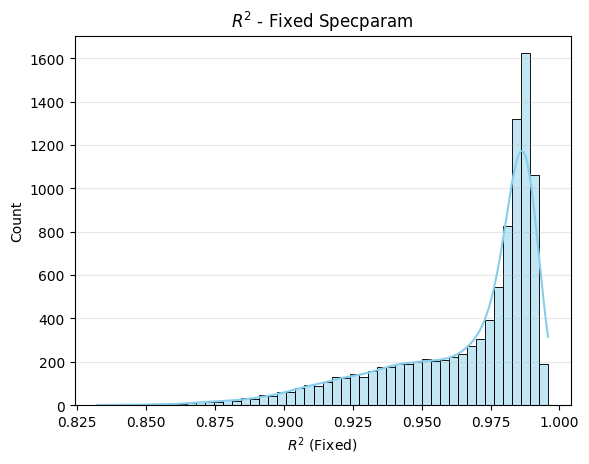

In [25]:
sns.histplot(data = eib_data, x = 'r2_linear', bins = 50, kde = True, color = 'skyblue', edgecolor = 'black')

plt.title('$R^2$ - Fixed Specparam')
plt.xlabel('$R^2$ (Fixed)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)

plt.show()

Note: The p-value and BF10 appear as NaN because the correlation is so strong that the values effectively underflow to zero.

In [26]:
# Spearman correlation between log(eib) and exp_linear
pg.corr(x = np.log(eib_data['eib']), y = eib_data['exp_linear'], method = 'pearson') 

,n,r,CI95%,p-val,BF10,power
pearson,10000,-0.963108,"[-0.96, -0.96]",0.0,nan,1.0


Both the duration of the $\Psi$ pattern and the spectral slope (exponent) obtained in the 40 – 85 Hz band show a very similar relationship with the EIB. Thus, we can observe that signals with fewer high-frequency components (a sharper $1/f$ decay indexed by a steeper spectral slope) also exhibit $\Psi$ patterns of longer duration.

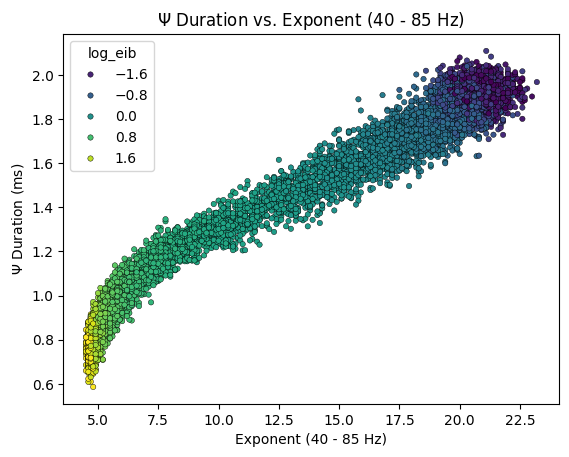

In [51]:
eib_data['log_eib'] = np.log10(eib_data['eib'])

sns.scatterplot(
    x = 'psi_duration', 
    y = 'exp_linear', 
    hue = 'log_eib',            
    data = eib_data, 
    s = 15, 
    palette = 'viridis',   
    alpha = 1.0,            
    edgecolor = 'black'        
)

plt.title('$\Psi$ Duration vs. Exponent (40 - 85 Hz)')
plt.xlabel('Exponent (40 - 85 Hz)')
plt.ylabel('$\Psi$ Duration (ms)')
plt.show()

##### **3. EIB and Spectral Parameterization (Double Exponent Mode in 1 - 300 Hz Frequency Range)**
We can observe that the *specparam* model in 'doublexp' mode, when fitted to the 1–300 Hz frequency band, provides a poor fit to the simulated data. This results in clear outliers, such as exponents with negative values or extremely high values (> 20).

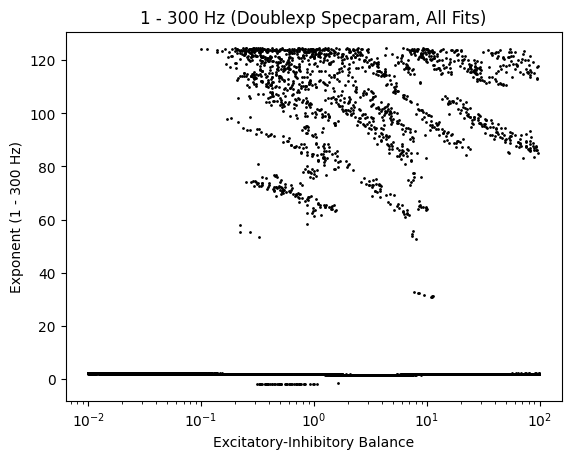

In [28]:
sns.scatterplot(
    x = 'eib', 
    y = 'exp_1', 
    data = eib_data, 
    s = 1, 
    color = 'black', 
    edgecolor = 'black', 
    linewidth = 1
)

plt.title('1 - 300 Hz (Doublexp Specparam, All Fits)')
plt.xlabel('Excitatory-Inhibitory Balance')
plt.ylabel('Exponent (1 - 300 Hz)')
plt.xscale('log')  
plt.show()

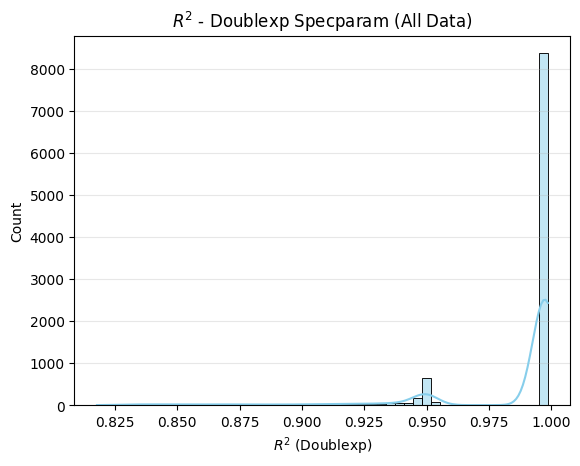

In [29]:
sns.histplot(data = eib_data, x = 'r2_dexp', bins = 50, kde = True, color = 'skyblue', edgecolor = 'black')

plt.title('$R^2$ - Doublexp Specparam (All Data)')
plt.xlabel('$R^2$ (Doublexp)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)

plt.show()

In [30]:
# We will subset only the 'good' fits 
mask = eib_data['exp_1'].between(1, 3)
subset = eib_data[mask]
outliers = eib_data[~mask]

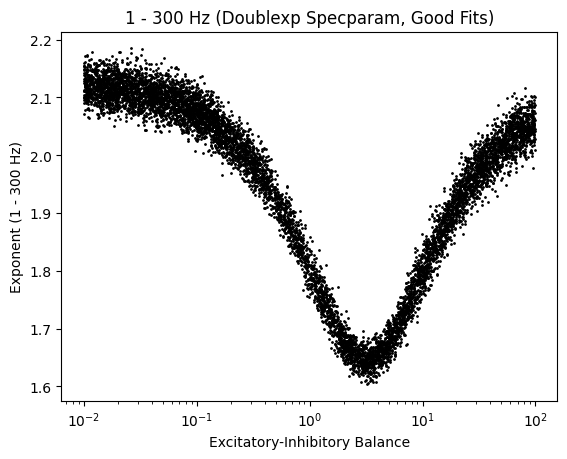

In [31]:
sns.scatterplot(
    x = 'eib', 
    y = 'exp_1', 
    data = subset, 
    s = 1, 
    color = 'black', 
    edgecolor = 'black', 
    linewidth = 1
)

plt.title('1 - 300 Hz (Doublexp Specparam, Good Fits)')
plt.xlabel('Excitatory-Inhibitory Balance')
plt.ylabel('Exponent (1 - 300 Hz)')
plt.xscale('log')  
plt.show()

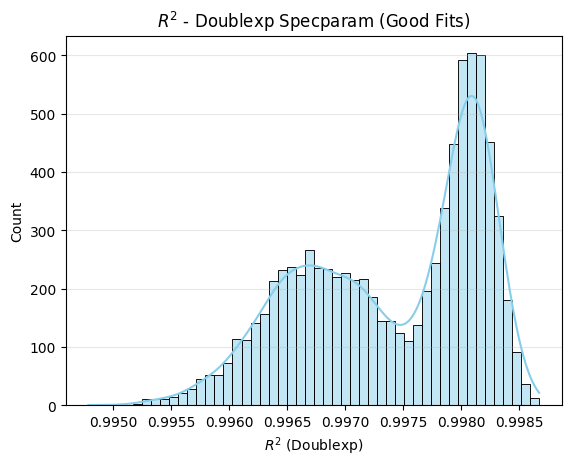

In [32]:
sns.histplot(data = subset, x = 'r2_dexp', bins = 50, kde = True, color = 'skyblue', edgecolor = 'black')

plt.title('$R^2$ - Doublexp Specparam (Good Fits)')
plt.xlabel('$R^2$ (Doublexp)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)

plt.show()

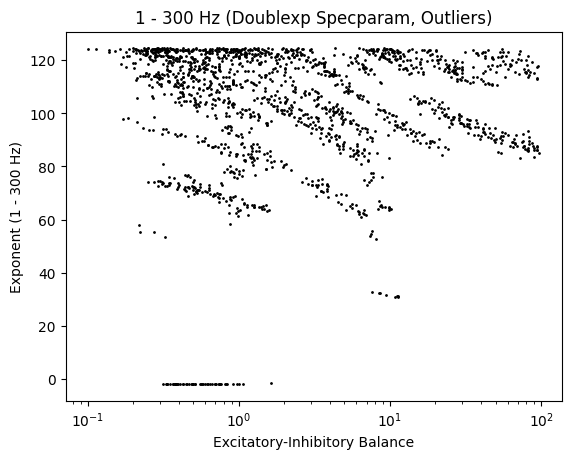

In [33]:
sns.scatterplot(
    x = 'eib', 
    y = 'exp_1', 
    data = outliers, 
    s = 1, 
    color = 'black', 
    edgecolor = 'black', 
    linewidth = 1
)

plt.title('1 - 300 Hz (Doublexp Specparam, Outliers)')
plt.xlabel('Excitatory-Inhibitory Balance')
plt.ylabel('Exponent (1 - 300 Hz)')
plt.xscale('log')  
plt.show()

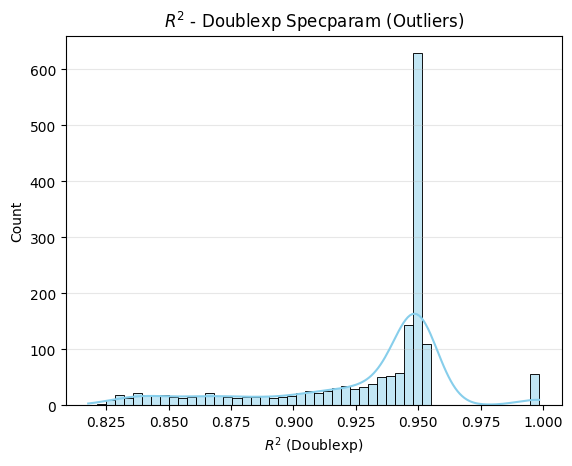

In [34]:
sns.histplot(data = outliers, x = 'r2_dexp', bins = 50, kde = True, color = 'skyblue', edgecolor = 'black')

plt.title('$R^2$ - Doublexp Specparam (Outliers)')
plt.xlabel('$R^2$ (Doublexp)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)

plt.show()

Despite this strong correlation, in those cases where a plausible fit is observed (exponents between 1 and 3), the obtained values do not reflect the changes in the EIB as effectively as the 'fixed' mode fit within the 40 – 85 Hz range.

In [35]:
# Spearman correlation between log(eib) and exp_1
pg.corr(x = np.log(subset['eib']), y = subset['exp_1'], method = 'pearson') 

,n,r,CI95%,p-val,BF10,power
pearson,8319,-0.50568,"[-0.52, -0.49]",NaN,inf,1.0


It is important to consider that the extremely small and significant p-values we have observed are due, in part, to the large volume of data (10000 samples) produced in the simulation.

##### **3.1 Example of a Poor Fit in the Doublexp Mode**

In [36]:
import numpy as np
np.random.seed(42)

# Signal parameters 
t_sec, fs = (300, 10000)
window_sec, overlap_sec = (2, 1)

# AMPA parameters 
n_ex, rate_ex, w_ex = (5000, 50, -1)
rise_ampa, decay_ampa = (0.2/1000, 2/1000) 

# GABA parameters
n_in, rate_in, w_in = (5000, 50, 1)
rise_gaba, decay_gaba = (0.5/1000, 10/1000) 

# AMPA kernel
kernel_ampa, time_ampa = dual_exponential(t_sec = t_sec, 
                                          fs = fs, 
                                          tau_rise_s = rise_ampa,
                                          tau_decay_s = decay_ampa, 
                                          max_amplitude = 1)

# GABAa kernel
kernel_gaba, time_gaba = dual_exponential(t_sec = t_sec, 
                                          fs = fs, 
                                          tau_rise_s = rise_gaba,
                                          tau_decay_s = decay_gaba, 
                                          max_amplitude = 1)

# Computing the signal
lfp_half, lfp_ex, lfp_in, time_lfp_half = simulate_fpp_balance(kernel_ex = kernel_ampa, 
                                                               kernel_in = kernel_gaba, 
                                                               fs = fs, 
                                                               t_sec = t_sec, 
                                                               n_ex = n_ex, 
                                                               n_in = n_in, 
                                                               rate_ex = rate_ex, 
                                                               rate_in = rate_in,
                                                               w_ex = w_ex,
                                                               w_in = w_in)

# PSD 
psd_half, freqs_half = averaged_multitaper_psd(signal = lfp_half, fs = fs, window_sec = window_sec, overlap_sec = overlap_sec, NW = 3)
# Recovering the kernel
psi_half, time_psi_half = averaged_psi_pattern(signal = lfp_half, fs = fs, window_sec = window_sec, overlap_sec = overlap_sec)

In [37]:
freq_range = [1, 300] 
aperiodic_mode = 'doublexp'

Aperiodic Params: [   3.32617138 -110.73940842   37.29755165  112.23138453]
Error: 0.09809608121325107
R2: 0.9489750809004631
                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                       The model was fit with the 'spectral_fit' algorithm                        
              Model was fit to the 1-300 Hz frequency range with 0.50 Hz resolution               
                                                                                                  
                              Aperiodic Parameters ('doublexp' mode)                              
                               (offset, exponent0, knee, exponent1)                               
                               3.3262, -110.7394, 37.2976, 112.2314               

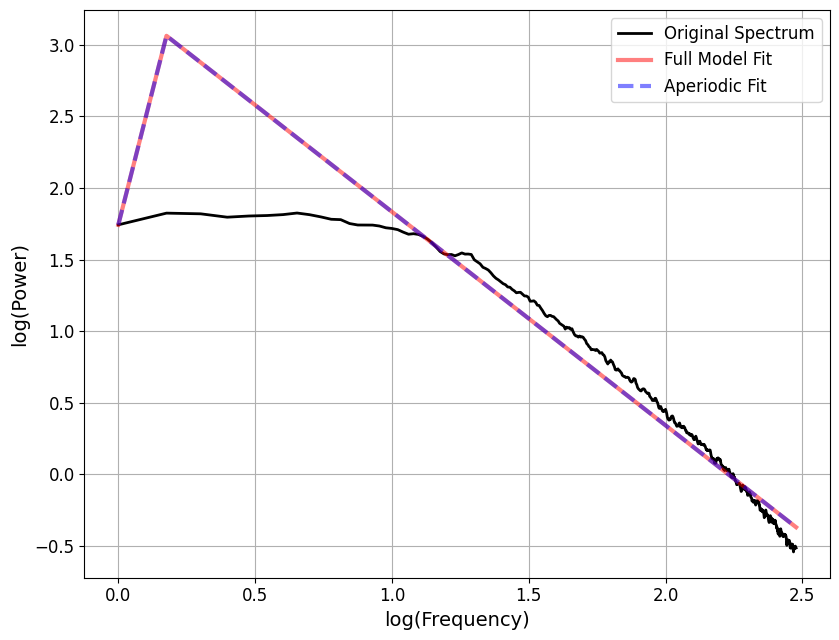

In [38]:
model_test = specparam(psd = psd_half, freqs = freqs_half, freq_range = freq_range, aperiodic_mode = aperiodic_mode, verbose = True)
model_test.report(freqs_half, psd_half, freq_range, plt_log = True)

Note that although the metrics (MAE and $R^2$) are not poor, we can easily determine visually that the fit was not performed correctly. In this case, we can see that the slope (exponent) obtained by the model is excessively high (exp_1 > 112).

---
##### **Conclusions** 
- Through this simulation, we observed how the balance between different kernel types coexisting within a signal is crucial in determining its overall dynamics. These dynamic shifts can be quantified using metrics derived from both the temporal profile of the $\Psi$ pattern and the frequency distribution (PSD).
- In the case of LFP/ECoG/EEG signals, the main components correspond to events related to synaptic kernels of AMPA and GABAa receptors. A shift in the excitation-inhibition balance toward excitation (AMPA) favors faster dynamics, which in turn manifest as a shorter $\Psi$ pattern and a greater predominance of high-frequency components.
- Interestingly, PSD-derived metrics are sensitive to the chosen frequency range and the specific fitting method employed. In this regard, the $\Psi$ pattern and its duration may represent a more stable metric that requires fewer arbitrary decisions to effectively quantify changes in EIB.


